In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [ ]:
gpus=tf.config.experimental.list_physical_devices('GPU')
#limiting the memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir='/content/drive/MyDrive/chest_xray/test'

In [ ]:
os.listdir(data_dir)

['PNEUMONIA', 'NORMAL']

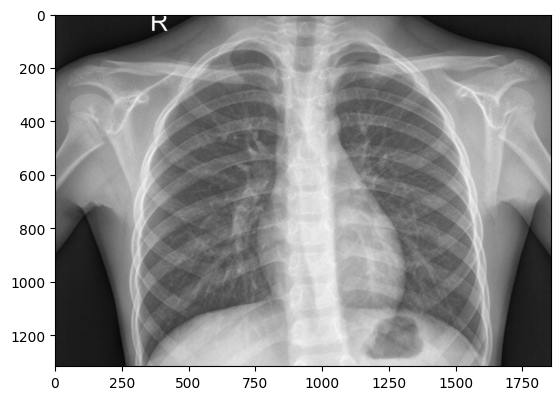

In [ ]:
img=cv2.imread(r'/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(img)

In [ ]:
import numpy as np

In [ ]:
data=tf.keras.utils.image_dataset_from_directory(data_dir,color_mode='grayscale')

Found 624 files belonging to 2 classes.


In [ ]:
data_iterator=data.as_numpy_iterator()
data_iterator

In [ ]:
batch=data_iterator.next()

In [ ]:
len(batch)

2

In [ ]:
batch[0].shape

(32, 256, 256, 1)

In [ ]:
batch[1]

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1], dtype=int32)

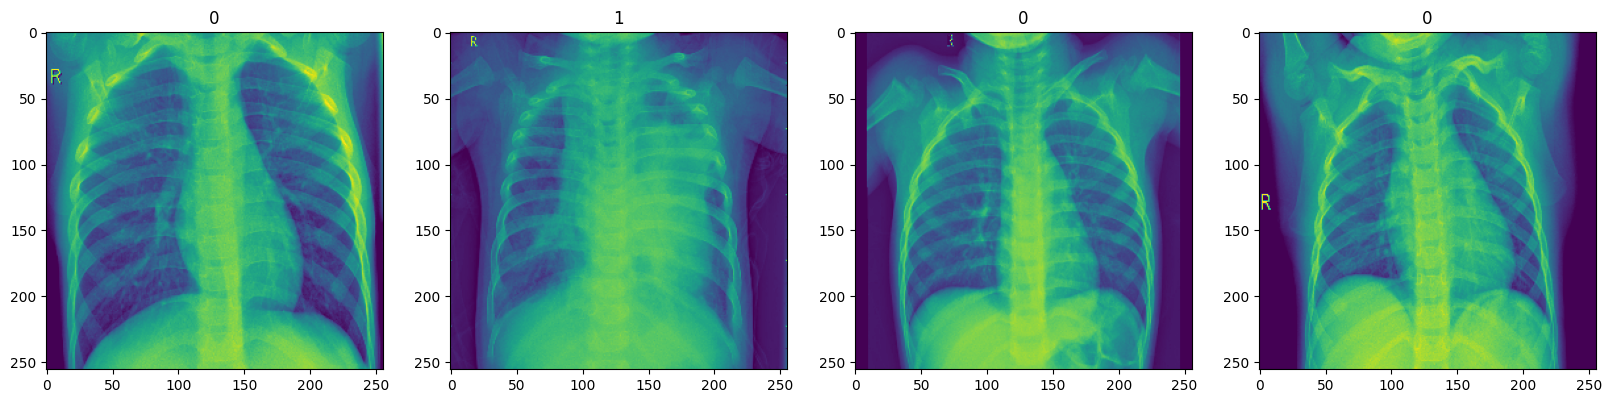

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
scaled=batch[0]/255
scaled.max()

1.0

In [ ]:
data=data.map(lambda x,y:(x/255,y))
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
scaled_iterator=data.as_numpy_iterator()

In [ ]:
batch=scaled_iterator.next()

In [ ]:
batch[0].max()

1.0

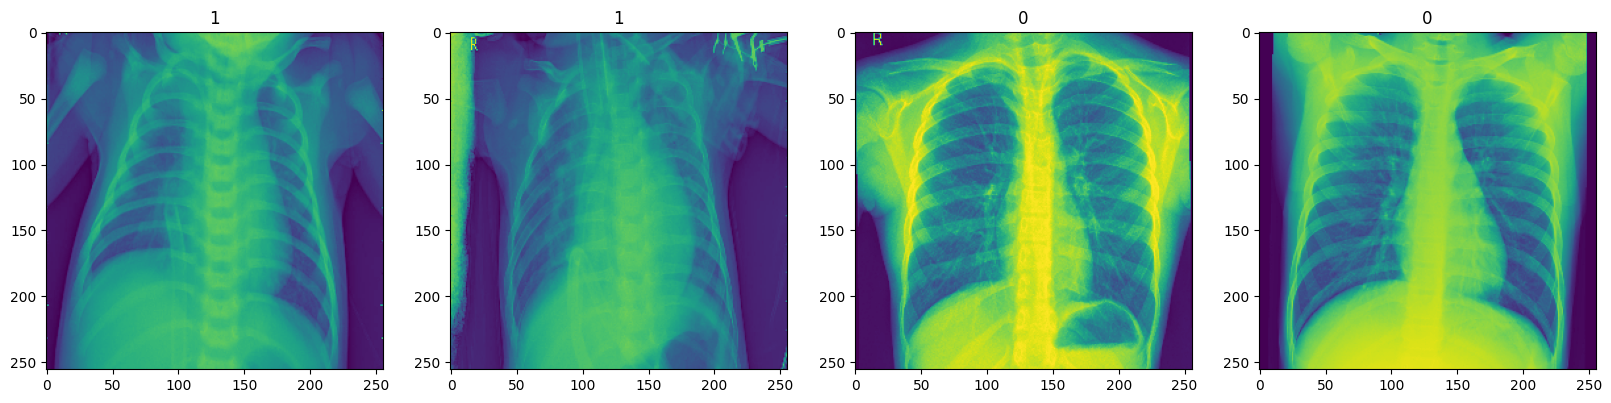

In [ ]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data)

20

In [ ]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)+1
test_size=int(len(data)*.1)+1

In [ ]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from keras.initializers import zeros,RandomNormal,RandomUniform,GlorotNormal,he_uniform
from keras.regularizers import l1,l2

In [ ]:
model=Sequential()

In [ ]:
model.add(Conv2D(16, (3, 3), activation='relu',
                 kernel_regularizer=l2(0.01),
                 input_shape=(256, 256, 1)))


model.add(MaxPooling2D())


model.add(Conv2D(32, (3, 3), activation='relu',
                 kernel_regularizer=l2(0.01)))


model.add(MaxPooling2D())


model.add(Conv2D(16, (3, 3), activation='relu',
                 kernel_regularizer=l2(0.01)))

# Add another max pooling layer
model.add(MaxPooling2D())

# Flatten the output for the fully connected layers
model.add(Flatten())

# Add a fully connected layer with L2 regularization (no specific weight initializer)
model.add(Dense(256, activation='relu',
                kernel_regularizer=l2(0.01)))

# Add a fully connected layer with L2 regularization (no specific weight initializer)
model.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l2(0.01)))


In [ ]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 30, 30, 16)      

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist=model.fit(train,epochs=3,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/3
14/14 [==============================] - 21s 1s/step - loss: 3.2021 - accuracy: 0.6250 - val_loss: 1.3192 - val_accuracy: 0.6313
Epoch 2/3
14/14 [==============================] - 20s 1s/step - loss: 1.1036 - accuracy: 0.6473 - val_loss: 0.9648 - val_accuracy: 0.8687
Epoch 3/3
14/14 [==============================] - 19s 1s/step - loss: 0.8310 - accuracy: 0.8214 - val_loss: 0.6079 - val_accuracy: 0.9187


In [ ]:
hist.history

{'loss': [0.2784857153892517,
  0.22913257777690887,
  0.21793289482593536,
  0.16611652076244354,
  0.15708503127098083],
 'accuracy': [0.8861607313156128,
  0.8995535969734192,
  0.9241071343421936,
  0.9397321343421936,
  0.9375],
 'val_loss': [0.28483837842941284,
  0.21568424999713898,
  0.13879740238189697,
  0.17488987743854523,
  0.08948162198066711],
 'val_accuracy': [0.8812500238418579,
  0.9125000238418579,
  0.9624999761581421,
  0.9375,
  0.987500011920929]}

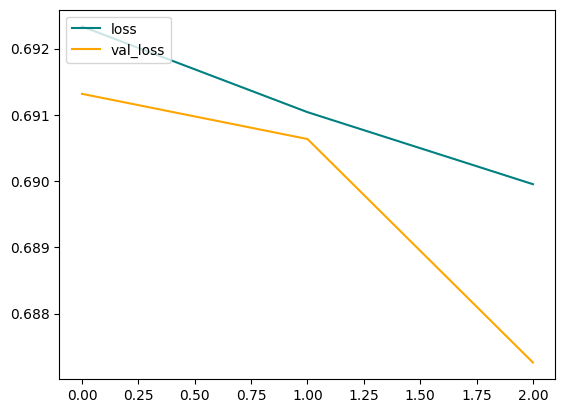

In [ ]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
plt.legend(loc="upper left")
plt.show()

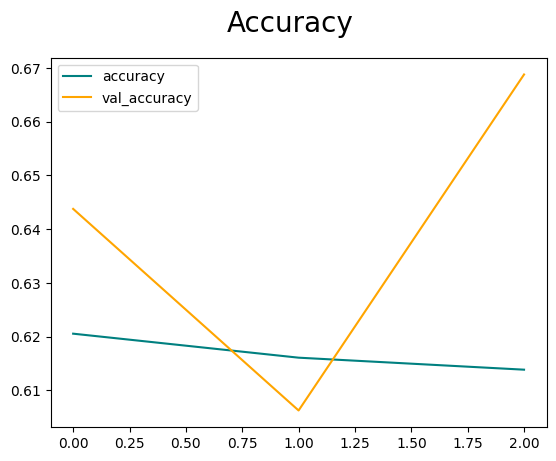

In [ ]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize =20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [ ]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [ ]:
print("Precision=",pre.result())
print("Recall=",re.result())
print("Accuracy",acc.result())

Precision= tf.Tensor(0.0, shape=(), dtype=float32)
Recall= tf.Tensor(0.0, shape=(), dtype=float32)
Accuracy tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
len(test)

1

In [ ]:
for batch in test.as_numpy_iterator():
    x,y=batch
    yhat=model.predict(x)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 179ms/step


In [ ]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy}')

Precision:0.625,Recall:1.0,Accuracy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.625>>
